In [26]:
%matplotlib inline

#version 1

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, display
# display(HTML("<style> .container { width:100%; }</style>")) #jupyter full screen width
# display(HTML("<style> .CodeMirror pre { font-size: 12pt; line-height: 110%;} </style>")) #jupyter font
figSize = (18,12) #figure size
lW = 1 #line width for graphs

In [27]:
l      = 1    # pendulum length, meters
pLenError = 0.9 # pendulum length error. TRY VARIOUS VALUES
g = 9.81   #gravitational acceleration
dT = 0.01  #simulation time increment
N = 1000   #time steps
v = 0 #initial velocity
iAngle     = np.pi/20  #initial angle
iAngleError = 0.00     #initial angle error. TRY VARIOUS VALUES

teta = iAngle
time = 0
vx = [] 
al = []
av = []
tList = []
angleList = []

for i in range(N):
    _al = g*np.cos(teta) - v*v/l
    _vx = v*np.cos(teta)
    _av = g*np.sin(teta)
    
    vx.append(_vx)
    al.append(_al)
    av.append(_av)
    angleList.append(teta)
    tList.append(time)
    
    time = time + dT
    
    v = v + _av * dT
    
    teta = teta -  v * dT / l

vxSS    = 0.04 # radar vx variance. TRY VARIOUS VALUES
vxBias  = 0.4 # radar systematic error. TRY VARIOUS VALUES
vx = vx + np.random.normal(vxBias, vxSS, N) 

alSS    = 0.04 # accelerometer variance. TRY VARIOUS VALUES
alBias  = 0.4 # accelerometer systematic error. TRY VARIOUS VALUES
al = al + np.random.normal(alBias, alSS, N) 

avSS    = 0.04 # accelerometer variance. TRY VARIOUS VALUES
avBias  = 0.4 # accelerometer systematic error. TRY VARIOUS VALUES
av = av + np.random.normal(avBias, avSS, N) 


inData = np.stack((tList, vx, [vxSS+vxBias*vxBias] * N, al, [alSS+alBias*alBias] * N, av, [avSS+avBias*avBias] * N)).T


In [28]:
# you need to improve this function 
# this solution does not improve use the radar data
# and, also, does not attempt to estimate the pendulum length, gyro and radar bias
# only works well if the gyro is accurate and has no bias.
# does not even use pendulum physics (gravitation?)

#       0      1       2    3     4      5      6   7
# x = [teta, tetad, tetadd, l, tetad_b, l_b, al_b, av_b]

def f(x, dt):
    return np.array([
        x[0] + x[1] * dt + x[2] * (dt**2) / 2,
        x[1] + x[2] * dt,
        g * np.sin(x[0]) / x[3],
        x[3],
        x[4],
        x[5],
        x[6],
        x[7]
    ])

def jacob_f(x, dt):
    return np.array([
        [1, dt, (dt**2) / 2, 0, 0, 0, 0, 0],
        [0, 1, dt, 0, 0, 0, 0, 0],
        [g * np.cos(x[0]) / x[3], 0, 0, -g * np.sin(x[0]) / (x[3]**2), 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1]
    ])

def h(x):
    return np.array([
        (x[1] + x[4]) * np.cos(x[0]), #(v + vb)costeta
        g * np.sin(x[0]) + x[7], #gsin(teta) + av_b
        g * np.cos(x[0]) - (x[1] ** 2) * (x[3] + x[5]) + x[6], #gcosteta - v^2 * (l - lb) + al_b
        x[3] + x[5] # l - lb
    ])

def jacob_h(x):
    return np.array([
        [-(x[1] + x[4]) * np.sin(x[0]), np.cos(x[0]), 0, 0, np.cos(x[0]), 0, 0, 0],
        [g * np.cos(x[0]), 0, 0, 0, 0, 0, 0, 1],
        [-g * np.sin(x[0]), -2 * x[1] * (x[3] + x[5]), 0, -(x[1] ** 2), 0, -(x[1] ** 2), 1, 0],
        [0, 0, 0, 1, 0, 1, 0, 0]
    ])


def estimateGyro(measurements, angle, pendLen, g):
    global vxSS, avSS, alSS, dT
    USE_BASELINE = False
    
    N = measurements.shape[0]
    oldT = 0
    aList = []
    v = 0
    P = np.identity(8)
    Q = (dT / 10) * np.identity(8)
    R = np.array([[vxSS, 0, 0, 0], [0, avSS, 0, 0], [0, 0, alSS, 0], [0, 0, 0, 0.4]])

    for i in range(N):
        (t, vx, vxSS, al, alSS, av, avSS) = tuple(measurements[i,:])
        dt = dT
        
        if not USE_BASELINE:
            if i == 0:
                x = np.array([angle, 0, g * np.sin(angle), pendLen, 0.01, 0.01, 0.01, 0.01])


            # Predict
            x_bar = f(x, dt)
            pendLen = x[3]
            F = jacob_f(x, dt)
            P_bar = F @ P @ F.T + Q
            # Update
            z = np.array([vx, av, al, pendLen])
            h_x = h(x_bar)
            H = jacob_h(x_bar)
            y = z - h_x
            K = P_bar @ H.T @ np.linalg.inv(H @ P_bar @ H.T + R)
            x = x_bar + K @ y
            P = (np.identity(8) - K @ H) @ P_bar @ (np.identity(8) - K @ H).T + K @ R @ K.T
            angle = x[0]
        else:
            # Baseline
            v = v + av * dt
            angle = angle - v * dt / pendLen
        aList.append(angle)
    return (aList, x[3], x[4], x[6], x[7]) 

RMS Angle Estimation Error: 0.4338767775376614
Estimated Pendulum Length: 1.1235689688908035  Real Penndulum length: 1
Estimated Radar bias: 0.2919766624861392  Real Radar bias: 0.4
 Estimated AccL bias: 0.3712095136805494   Real AccL bias: 0.4
 Estimated AccV bias: 0.3757614525911734   Real AccV bias: 0.4


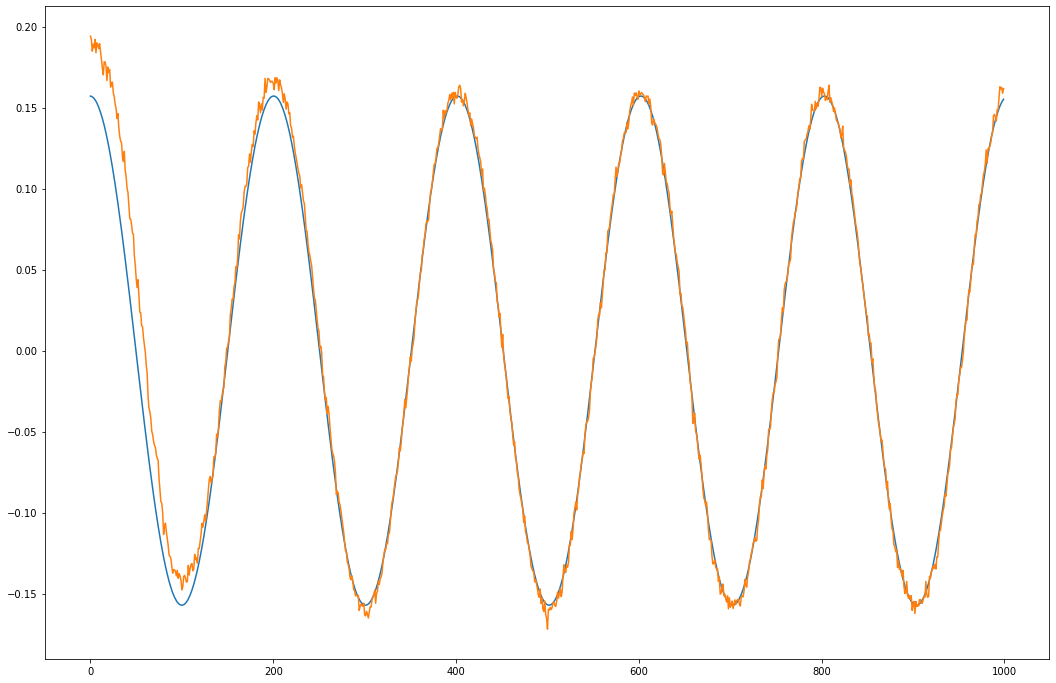

In [29]:
    
    
(e_aList, e_penLen, e_vxBias, e_alBias, e_avBias) = estimateGyro(inData, iAngle+iAngleError, l+pLenError, g)

fig, ax = plt.subplots(figsize=figSize)
ax.plot(angleList) # the real angle
#ax.plot(w)
ax.plot(e_aList) # the estimated angle, obviously drifting due to gyroBias (constant error in the angular velocity speed)

print('RMS Angle Estimation Error:', np.sqrt(np.sum((np.array(e_aList)-np.array(angleList))**2)))
print('Estimated Pendulum Length:',e_penLen,' Real Penndulum length:', l)
print('Estimated Radar bias:', e_vxBias,' Real Radar bias:', vxBias)
print(' Estimated AccL bias:', e_alBias,'  Real AccL bias:', alBias)
print(' Estimated AccV bias:', e_avBias,'  Real AccV bias:', avBias)
